# Vanilla Autoencoder

In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings

2022-11-05 14:09:32.081178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset Loading

In [2]:
fmnist_train = datasets.FashionMNIST(root='Fashion_mnist/',train=True,transform=ToTensor(),download=False)
fmnist_test  = datasets.FashionMNIST(root='Fashion_mnist/',train=False,transform=ToTensor(),download=False)

In [3]:
cifar10_train = datasets.CIFAR10(root='CIFAR-10/',train=True,transform=ToTensor(),download=False)
cifar10_test = datasets.CIFAR10(root='CIFAR-10/',train=False,transform=ToTensor(),download=False)

In [4]:
fmnist_train_loader = DataLoader(dataset=fmnist_train,batch_size=32) 
fmnist_test_loader = DataLoader(dataset=fmnist_test,batch_size=32)  

In [5]:
cifar10_train_loader = DataLoader(dataset=cifar10_train,batch_size=32)
cifar10_test_loader = DataLoader(dataset=cifar10_test,batch_size=32)

You can play with batch size.

In [6]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def visualize_dataset(example_data,example_targets,channel_size):
    
    if channel_size==3:
        fig = plt.figure()
        
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(np.transpose(example_data[i],(1, 2, 0)))
            plt.title("Ground Truth: {}".format(example_targets[i]))
            plt.xticks([])
            plt.yticks([])
        
    if channel_size == 1:
        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(example_data[i][0], cmap='gray')
            plt.title("Ground Truth: {}".format(example_targets[i]))
            plt.xticks([])
            plt.yticks([])

# Visualize Fashion-MNIST

In [8]:
fmnist_examples = enumerate(fmnist_train_loader)
_, (example_data, example_targets) = next(fmnist_examples)

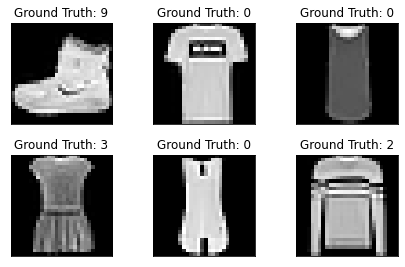

In [9]:
visualize_dataset(example_data,example_targets,channel_size=1) #channel size for F-MNIST is 1 

In [10]:
fmnist_train_loader.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

# Visualize CIFAR-10

In [11]:
cifar10_examples = enumerate(cifar10_train_loader)
batch_idx, (example_data,example_targets) = next(cifar10_examples)

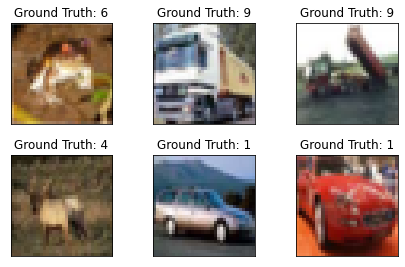

In [12]:
visualize_dataset(example_data,example_targets,channel_size=3) # channel size for CIFAR-10 is 3

In [13]:
cifar10_train_loader.dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [14]:
class AE(nn.Module):
    
    def __init__(self,input_dim,latent_dim=10):
        
        super(AE,self).__init__()
        
        self.encoder = nn.Sequential(
            
            nn.Linear(input_dim,128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,latent_dim),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            
            nn.Linear(latent_dim,64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.LeakyReLU(),
            nn.Linear(128,input_dim),
            nn.LeakyReLU(),
        
        )
        
    def forward(self,x):
        
        x = x.view(x.size(0),-1)
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
        

In [15]:
def train(model,train_dataloader,optimizer,loss_fn,EPOCH):
    
    
    #tqdm is for the progress bar. It has nothing to do with the training.
    with tqdm(total = len(train_dataloader) * EPOCH) as tt:
        model.train()
        model = model.to(device)
        for epoch in range(EPOCH):

            total_loss, batch_count = 0, 0



            for idx, (batch,_) in enumerate(train_dataloader):
                
                batch = batch.to(device)
                batch = batch.view(batch.size(0),-1)  # If you don't do this there will occur an error while training the model and calculating the loss. *Shape problem* 
                output = model(batch) # forward prop :)
                
                loss = loss_fn(output,batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                total_loss  += loss.item()
                batch_count += 1
                tt.update()

            total_loss = total_loss / batch_count
            print(f'{total_loss}')


In [16]:
def visualize_results(model,data_loader):
    dataiter = iter(data_loader)
    
    images, labels = dataiter.next()
    batch_size = images.size(0) 
    channel_size = images.size(1)
    w_h = images.size(2)
    
    if next(model.encoder.parameters()).shape[1] != 3:
        images_flatten = images.view(batch_size, -1)
        output = model(images_flatten.to(device))
    else:
        output = model(images.to(device))
    
    images = images.numpy()
    output = output.view(batch_size, channel_size, w_h, w_h)
    output = output.cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            
            ax.imshow((np.transpose(img,(1, 2, 0))*255).astype(np.uint8),cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

# Fashion MNIST trainingset_visible

In [17]:
#fmnist_model = AE(input_dim=28*28)
#torch.save(fmnist_model,'models/fmnist.pt')
fmnist_model = torch.load('models/fmnist.pt')
fmnist_model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

In [18]:
#f_optimizer = Adam(fmnist_model.parameters(),lr=2e-3)
#loss_fn    = nn.MSELoss()
#train(model=fmnist_model,train_dataloader=fmnist_train_loader,optimizer=f_optimizer,loss_fn=loss_fn,EPOCH=50)

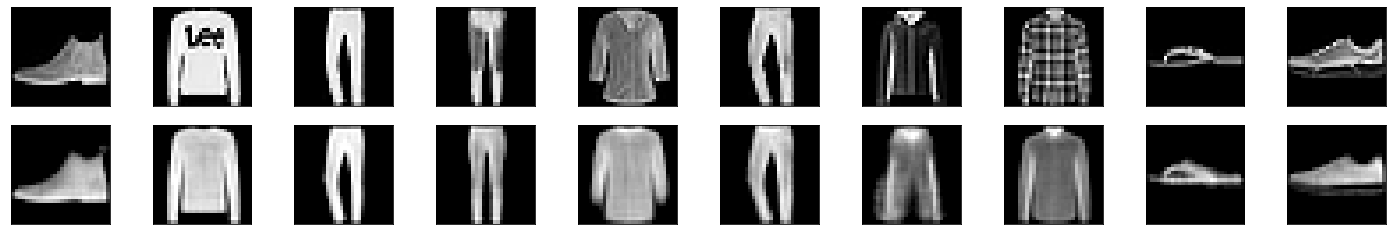

In [19]:
visualize_results(model=fmnist_model,data_loader=fmnist_test_loader)

# CIFAR-10 training

In [20]:
#torch.save(cifar_linear_model,'models/cifar10_linear.pt')
cifar_linear_model = torch.load('models/cifar10_linear.pt')
cifar_linear_model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=3072, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

In [21]:
#optimizer = Adam(cifar_linear_model.parameters(),lr=3e-3)
#loss_fn = nn.MSELoss()
#train(model=cifar_linear_model,train_dataloader=cifar10_train_loader,optimizer=optimizer,loss_fn=loss_fn,EPOCH=30)

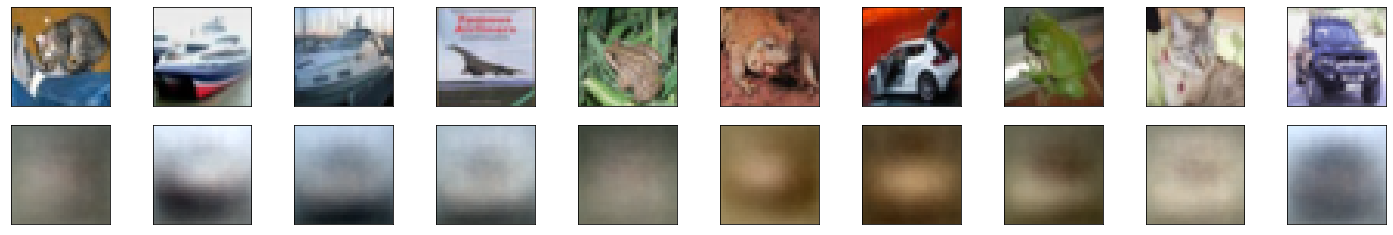

In [22]:
# CIFAR-10 with MLP
visualize_results(model=cifar_linear_model,data_loader=cifar10_test_loader)

# Convolutional Autoencoder

In [23]:
class ConvAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=3,out_channels=32,stride=1,kernel_size=5), #32x32x3 --> 28x28x32
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=32,stride=1,kernel_size=3), #28x28x32 --> 26x26x32
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=32,stride=2,kernel_size=4), #26x26x32 --> 12x12x32
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,stride=1,kernel_size=3), #12x12x32 --> 10x10x64
            nn.LeakyReLU(),
        )
        
        self.latent_space  = nn.Sequential( 
            nn.Linear(6400,400),
            nn.LeakyReLU(),
            nn.Linear(400,6400)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=1,kernel_size=3), # 10x10x64 --> 12x12x32
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=32,stride=2,kernel_size=4), # 12x12x32 --> 26x26x32
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=32,stride=1,kernel_size=3), # 26x26x32 --> 28x28x16
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32,out_channels=3,stride=1,kernel_size=5), # 28x28x16 --> 32x32x3
        )
    def forward(self, x):
        
        x = self.encoder(x)
        x = x.view(x.size(0),-1)
        x = self.latent_space(x)
        x = x.view(x.size(0),64,10,10)
        x = self.decoder(x)
        
        
        return x

In [24]:
def conv_train(model,train_dataloader,optimizer,loss_fn,EPOCH=30):
    
    with tqdm(total = len(train_dataloader) * EPOCH) as tt:
        
        model.train()
        
        for epoch in range(EPOCH):
            
            total_loss, batch_count = 0, 0
            
            for idx,(batch,_) in enumerate(train_dataloader):
                
                output = model(batch)
                
                loss = loss_fn(output,batch)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
                total_loss += loss.item()
                batch_count += 1
                tt.update()
                
            total_loss = total_loss / batch_count
            print(f'{total_loss}')


In [25]:
#loss_fn = nn.MSELoss()
#optimizer = Adam(convAE.parameters(),lr=1e-3) #### optimizer for convAE

In [26]:
cifar_conv3e3_model = torch.load('models/cifar10_conv_3e-3.pt',map_location=torch.device('cpu'))
cifar_conv3e3_model.eval()

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (latent_space): Sequential(
    (0): Linear(in_features=6400, out_features=2000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2000, out_features=6400, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTran

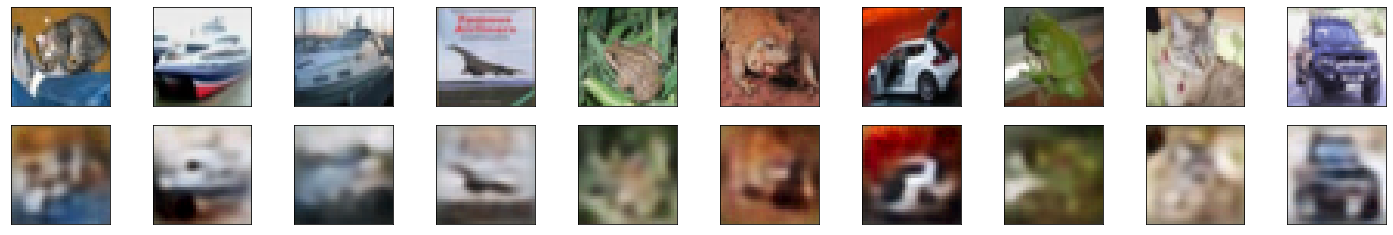

In [27]:
visualize_results(cifar_conv3e3_model,data_loader=cifar10_test_loader) 

In [28]:
cifar_conv5e4_model = torch.load('models/cifar10_conv_5e-4.pt',map_location=torch.device('cpu'))
cifar_conv5e4_model.eval()

ConvAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
  )
  (latent_space): Sequential(
    (0): Linear(in_features=6400, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=400, out_features=6400, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTransp

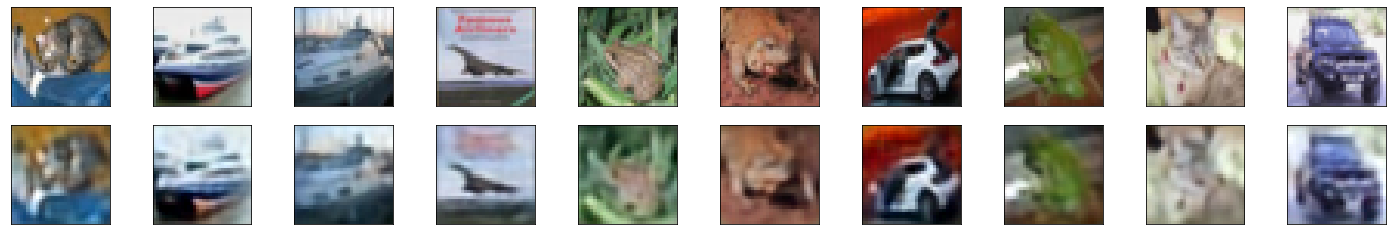

In [29]:
visualize_results(cifar_conv5e4_model,data_loader=cifar10_test_loader);

# Sampling from AE

Can we sample from Autoencoders? Let's try it.

In [30]:
rand_features = torch.randn(6,64,10,10) # 6--> sample size  
                                        # 64,10,10 --> decoder's input size

In [31]:
gen = cifar_conv5e4_model.decoder(rand_features)

In [32]:
gen = gen.detach().numpy()
gen = (gen*255).astype(np.uint8)

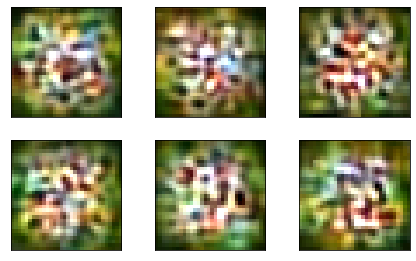

In [33]:
for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(np.transpose(gen[i],(1, 2, 0)))
            plt.xticks([])
            plt.yticks([])

As you can see we have something meaningless. Maybe we can't see but model can (?) :D


# Visualizing Encoded Data

UMAP is a fairly flexible non-linear dimension reduction algorithm. It seeks to learn the manifold structure of your data and find a low dimensional embedding that preserves the essential topological structure of that manifold.

In [34]:
def visualize2d_interactive(data,targets,classes):
    
    hover_data = pd.DataFrame({'index':np.arange(len(data)),
                               'label':targets})
    
    hover_data['item'] = hover_data.label.map(classes)
    mapping = umap.UMAP().fit(data)
    umap.plot.output_notebook()
    p = umap.plot.interactive(mapping, labels=targets, hover_data=hover_data, point_size=2,)
    umap.plot.show(p)
    
    

In [35]:
def visualize2d(data,targets):
    
    mapping = umap.UMAP().fit(data)
    umap.plot.points(mapping,labels=targets, theme='fire');

## F-MNIST Latent Space

Latent space is a 10-dimensional vector space but using U-Map we map the space to 2-dimensional vector space

In [36]:
############ F-MNIST LATENT SPACE ############
###################################################
f_test_data = fmnist_test_loader.dataset.data
f_targets = fmnist_test_loader.dataset.targets

f_test_data = f_test_data.view(10000,-1)
f_encoded_data = fmnist_model.encoder(f_test_data.float())

f_encoded_data = f_encoded_data.detach().numpy()
f_test_data    = f_test_data.detach().numpy()

f_classes = fmnist_test_loader.dataset.class_to_idx
f_classes = {y: x for x, y in f_classes.items()}
###################################################

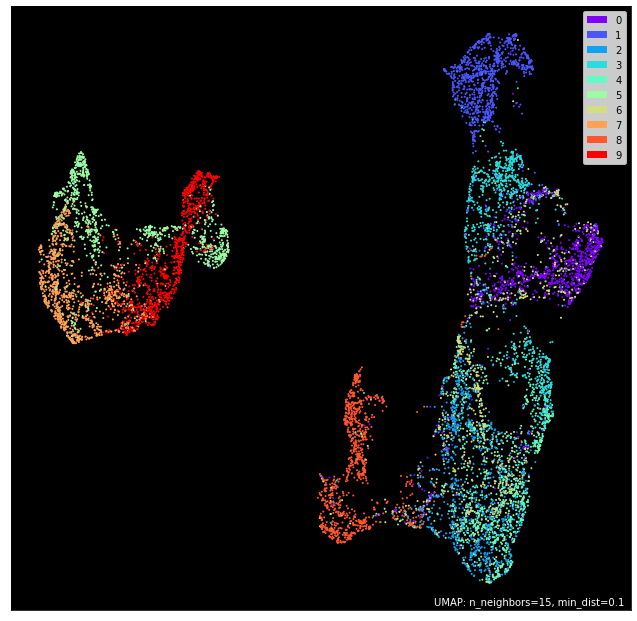

In [37]:
visualize2d(f_encoded_data,f_targets)

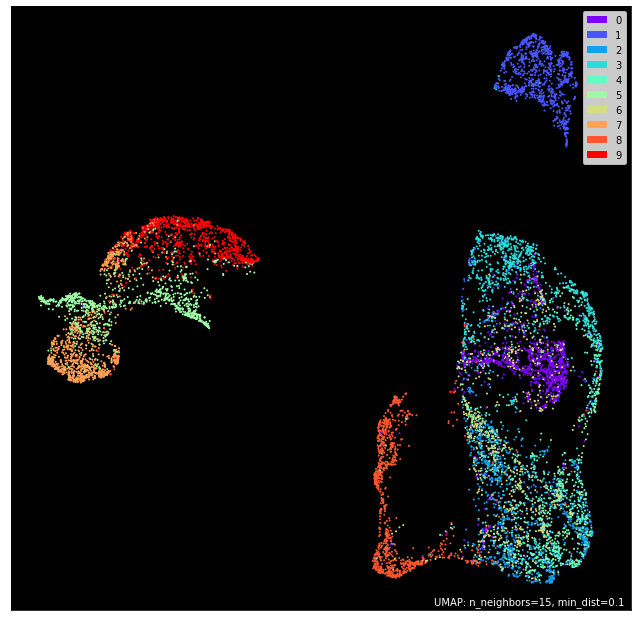

In [38]:
visualize2d(f_test_data,f_targets)

In [39]:
visualize2d_interactive(data=f_encoded_data,targets=f_targets,classes=f_classes)

Loading BokehJS ...

## CIFAR10 LATENT SPACE (Optional HW)

In [40]:
############ CIFAR10 LATENT SPACE ############
###################################################
###################################################

# Optional (Another implementation)

**You can use the same training functions to train your networks**

In [41]:
class Encoder():
    pass
class Decoder():
    pass
class AE():
    pass

In [42]:
class convEncoder():
    pass
class convDecoder():
    pass
class convAutoencoder():
    pass